In [1]:
import os
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tres.impl_at1 as tres
import torch


mhsa = tres.MultiHeadSelfAttentionBlock()
ffn = tres.FeedForwardNetworkBlock()
trans = tres.TransformerBlock()

#zakładamy że jest to już po flatten
testData = torch.rand((1,32,64))


print("input shape: ", testData.shape)

omsa = mhsa.forward(testData)

print("msa output shape: ", omsa.shape)

offn = ffn.forward(omsa)

print("ffn output shape: ", offn.shape)

otrans = trans.forward(testData)

print("transformer output shape: ", otrans.shape)


input shape:  torch.Size([1, 32, 64])
msa output shape:  torch.Size([1, 32, 64])
ffn output shape:  torch.Size([1, 32, 64])
transformer output shape:  torch.Size([1, 32, 64])


In [4]:
from torchinfo import summary
def printModelData(model):
  print(summary(
    model=model,
    input_size=(1,3,224,224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    row_settings=['var_names']))

In [5]:
from torch import nn

ap = nn.AdaptiveAvgPool2d((7,7))

In [6]:
from Datasets.CLIVEDataset import CLIVEDataset, CLIVE_PATH
from torch import nn
from torchvision.transforms import v2

trans = v2.Compose([
    v2.RandomHorizontalFlip(0.5),
    v2.RandomVerticalFlip(0.5),
    v2.RandomCrop((224,224)),
    # v2.Resize((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])
transTest = v2.Compose([
    v2.Resize((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])
transTest2 = v2.Compose([
    v2.RandomCrop((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])


trainDataset = CLIVEDataset(CLIVE_PATH, True,trans)
testDataset = CLIVEDataset(CLIVE_PATH, False,transTest2)

/home/mrpaw/.local/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [7]:
len(trainDataset)

929

In [7]:
from torch.utils.data import DataLoader

batch_size = 8
trainDataLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True,num_workers=2)
testDataLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=True,num_workers=2)

In [8]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
cpu = 'cpu'
device

'cuda'

In [9]:
from helpersmag.trainer import trainLoop

maghelper


/home/mrpaw/Documents/Projects/Python/PytorchTestRocm/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:

imgs1, lbls1 = next(iter(trainDataLoader))
print(imgs1.shape)
print(imgs1.max())
print(imgs1.min())
print(lbls1.shape)

torch.Size([8, 3, 224, 224])
tensor(2.6400)
tensor(-2.1179)
torch.Size([8, 1])


In [48]:
import org.data_loader as data_loader
import org.posencode as posencode

class Conf:
    datapath = "/home/mrpaw/Documents/mag_databases/LIVEC_or_CLIVE/ChallengeDB_release/ChallengeDB_release"
    dataset = "clive"
    seed = 2021
    svpath = "save"
    train_patch_num = 20#50 #ilość losowych paczy na batch
    test_patch_num = 20#50 #ilość losowych paczy na batch
    lr = 2e-5
    weight_decay = 5e-4
    batch_size = 10
    epochs = 1#3
    vesion = 1
    patch_size = 224
    droplr = 0 #1
    gpunum = 0
    network = 'resnet50'
    nheadt = 16
    num_encoder_layerst = 2
    dim_feedforwardt = 64

config = Conf()


In [49]:
import random
folder_path = {
    'live':     config.datapath,
    'csiq':     config.datapath,
    'tid2013':  config.datapath,
    'kadid10k': config.datapath,
    'clive':    config.datapath,
    'koniq':    config.datapath,
    'fblive':   config.datapath,
    }

img_num = {
    'live':     list(range(0, 29)),
    'csiq':     list(range(0, 30)),
    'kadid10k': list(range(0, 80)),
    'tid2013':  list(range(0, 25)),
    'clive':    list(range(0, 1162)),
    'koniq':    list(range(0, 10073)),
    'fblive':   list(range(0, 39810)),
    }

total_num_images = img_num[config.dataset]


# Randomly select 80% images for training and the rest for testing
random.shuffle(total_num_images)
train_index = total_num_images[0:int(round(0.8 * len(total_num_images)))]
test_index = total_num_images[int(round(0.8 * len(total_num_images))):len(total_num_images)]
train_idx = train_index
test_idx= test_index

In [50]:


datapath = folder_path[config.dataset]

train_loader = data_loader.DataLoader(config.dataset, datapath, 
											  train_idx, config.patch_size, 
											  config.train_patch_num, 
											  batch_size=config.batch_size, istrain=True)
		
test_loader = data_loader.DataLoader(config.dataset, datapath,
                                        test_idx, config.patch_size,
                                        config.test_patch_num, istrain=False)

In [51]:
trainDataLoader1 = train_loader.get_data()
testDataLoader1 = test_loader.get_data()

imgs, lbls = next(iter(trainDataLoader1))
print(imgs.shape)
print(imgs.max())
print(imgs.min())
print(lbls.shape)

timgs, tlbls = next(iter(testDataLoader1))
print(timgs.shape)
print(timgs.max())
print(timgs.min())
print(tlbls.shape)
tlbls.unsqueeze(0).shape

torch.Size([10, 3, 224, 224])
tensor(2.6400)
tensor(-2.1179)
torch.Size([10])
torch.Size([1, 3, 224, 224])
tensor(2.6400)
tensor(-2.0323)
torch.Size([1])


torch.Size([1, 1])

In [52]:
print(trainDataLoader1.__len__(), testDataLoader1.__len__())
print(len(train_idx), len(test_idx))



1860 4640
930 232


In [13]:
from org.models import Net

In [ ]:

model = Net(config, "cuda")

/home/mrpaw/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mrpaw/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
inputImg = imgs[0].unsqueeze(0)
inputImg.shape

torch.Size([1, 3, 224, 224])

In [36]:
model = model.cuda()
inputImg = inputImg.cuda()

res = model.forward(inputImg)

In [37]:
len(res), type(res)

(2, tuple)

In [38]:
preds, consistLoss = res

In [39]:
preds.shape

torch.Size([1, 1])

In [30]:
steps = 1

In [31]:

lossFn = nn.L1Loss()

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-4)

In [27]:
del model


In [33]:
import gc 
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/1 [00:00<?, ?it/s]

  Training... 4650/4650, lr nn, Avg Loss: 7.5796, SRCC: 0.8465, PLCC: 0.8595, MAE: 7.5780, COS: 0.9835						
  Testing... 11600/11600, Avg Loss: 23.1612, SRCC: 0.7156, PLCC: 0.7727, MAE: 23.1592, COS: 0.9806				

100%|██████████| 1/1 [35:15<00:00, 2115.52s/it]


Best acc  0.7155806


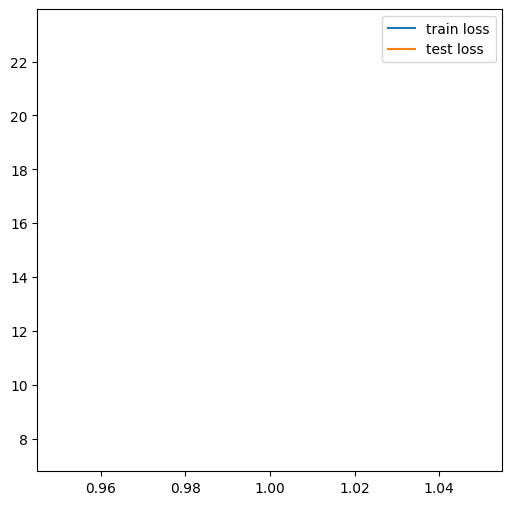

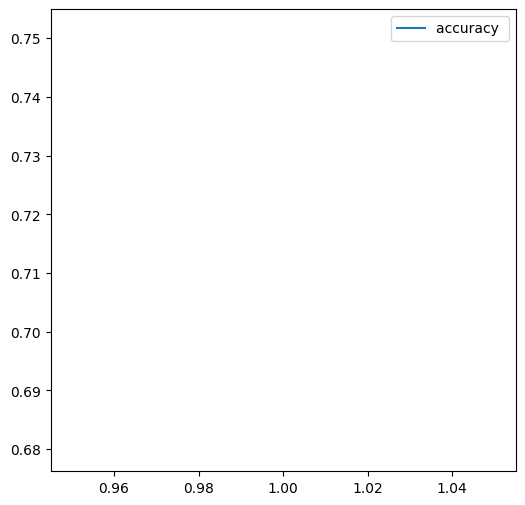

In [55]:
trainLoop(model, trainDataLoader1, testDataLoader1, optimizer, lossFn, steps, 'cuda', save=False)
# trainLoop(model, trainDataLoader, testDataLoader, optimizer, lossFn, steps, device, lrScheluder,scheluderStepsPerEpoch=1)

In [53]:
import torch
import torchvision.models as models
import torchvision
import torch.nn.functional as F
from torch import nn, Tensor

import numpy as np
from scipy import stats
from tqdm import tqdm
import os
import math
import csv
import copy
import json
from typing import Optional, List

import org.data_loader as data_loader
from org.transformers import Transformer
from org.posencode import PositionEmbeddingSine

class TReS(object):
	
	def __init__(self, config, device,  svPath, datapath, train_idx, test_idx,Net, model = None):
		super(TReS, self).__init__()
		
		self.device = device
		self.epochs = config.epochs
		self.test_patch_num = config.test_patch_num
		self.l1_loss = torch.nn.L1Loss()
		self.lr = 2e-5
		self.lrratio = 10
		self.weight_decay = config.weight_decay
		self.net = Net(config,device).to(device) if model == None else model
		self.droplr = config.droplr
		self.config = config
		self.clsloss =  nn.CrossEntropyLoss()
		self.paras = [{'params': self.net.parameters(), 'lr': self.lr} ]
		self.solver = torch.optim.Adam(self.paras, weight_decay=self.weight_decay)


		train_loader = data_loader.DataLoader(config.dataset, datapath, 
											  train_idx, config.patch_size, 
											  config.train_patch_num, 
											  batch_size=config.batch_size, istrain=True)
		
		test_loader = data_loader.DataLoader(config.dataset, datapath,
											 test_idx, config.patch_size,
											 config.test_patch_num, istrain=False)
		
		
		self.train_data = train_loader.get_data()
		self.test_data = test_loader.get_data()

		
	def train(self,seed,svPath):
		best_srcc = 0.0
		best_plcc = 0.0
		print('Epoch\tTrain_Loss\tTrain_SRCC\tTest_SRCC\tTest_PLCC\tLearning_Rate\tdroplr')
		steps = 0
		results = {}
		performPath = svPath +'/' + 'PLCC_SRCC_'+str(self.config.vesion)+'_'+str(seed)+'.json'
		with open(performPath, 'w') as json_file2:
			json.dump(  {} , json_file2)

		
		# self.testStep(self.net,self.test_data,'cuda')
		
		for epochnum in range(self.epochs):
			self.net.train()
			epoch_loss = []
			pred_scores = []
			gt_scores = []
			pbar = tqdm(self.train_data, leave=False)

			for img, label in pbar:
				img = torch.as_tensor(img.to(self.device)).requires_grad_(False)
				label = torch.as_tensor(label.to(self.device)).requires_grad_(False)

				steps+=1
				
				self.net.zero_grad()

				pred,closs = self.net(img)
				# pred2,closs2 = self.net(torch.flip(img, [3]))  

				pred_scores = pred_scores + pred.flatten().cpu().tolist()
				gt_scores = gt_scores + label.cpu().tolist()

				loss_qa = self.l1_loss(pred.squeeze(), label.float().detach())
				# loss_qa2 = self.l1_loss(pred2.squeeze(), label.float().detach())
				# =============================================================================
				# =============================================================================

				# indexlabel = torch.argsort(label) # small--> large
				# # print("len ", len(indexlabel))
				# anchor1 = torch.unsqueeze(pred[indexlabel[0],...].contiguous(),dim=0) # d_min
				# positive1 = torch.unsqueeze(pred[indexlabel[1],...].contiguous(),dim=0) # d'_min+
				# negative1_1 = torch.unsqueeze(pred[indexlabel[-1],...].contiguous(),dim=0) # d_max+

				# anchor2 = torch.unsqueeze(pred[indexlabel[-1],...].contiguous(),dim=0)# d_max
				# positive2 = torch.unsqueeze(pred[indexlabel[-2],...].contiguous(),dim=0)# d'_max+
				# negative2_1 = torch.unsqueeze(pred[indexlabel[0],...].contiguous(),dim=0)# d_min+

				# # =============================================================================
				# # =============================================================================

				# fanchor1 = torch.unsqueeze(pred2[indexlabel[0],...].contiguous(),dim=0)
				# fpositive1 = torch.unsqueeze(pred2[indexlabel[1],...].contiguous(),dim=0)
				# fnegative1_1 = torch.unsqueeze(pred2[indexlabel[-1],...].contiguous(),dim=0)

				# fanchor2 = torch.unsqueeze(pred2[indexlabel[-1],...].contiguous(),dim=0)
				# fpositive2 = torch.unsqueeze(pred2[indexlabel[-2],...].contiguous(),dim=0)
				# fnegative2_1 = torch.unsqueeze(pred2[indexlabel[0],...].contiguous(),dim=0)



				# consistency = nn.L1Loss()
				# assert (label[indexlabel[-1]]-label[indexlabel[1]])>=0
				# assert (label[indexlabel[-2]]-label[indexlabel[0]])>=0
				# triplet_loss1 = nn.TripletMarginLoss(margin=(label[indexlabel[-1]]-label[indexlabel[1]]), p=1) # d_min,d'_min,d_max
				# # triplet_loss2 = nn.TripletMarginLoss(margin=label[indexlabel[0]], p=1)
				# triplet_loss2 = nn.TripletMarginLoss(margin=(label[indexlabel[-2]]-label[indexlabel[0]]), p=1)
				# # triplet_loss1 = nn.TripletMarginLoss(margin=label[indexlabel[-1]], p=1)
				# # triplet_loss2 = nn.TripletMarginLoss(margin=label[indexlabel[0]], p=1)
				# tripletlosses = triplet_loss1(anchor1, positive1, negative1_1) + \
				# 	triplet_loss2(anchor2, positive2, negative2_1)
				# ftripletlosses = triplet_loss1(fanchor1, fpositive1, fnegative1_1) + \
				# 	triplet_loss2(fanchor2, fpositive2, fnegative2_1)
				
				# loss = loss_qa + closs + loss_qa2 + closs2 + 0.5*( self.l1_loss(tripletlosses,ftripletlosses.detach())+ self.l1_loss(ftripletlosses,tripletlosses.detach()))+0.05*(tripletlosses+ftripletlosses)
				# loss = loss_qa + loss_qa2
				loss = loss_qa 
				
				epoch_loss.append(loss.item())
				loss.backward()
				self.solver.step()
				

			
			
	
			modelPath = svPath + '/model_{}_{}_{}'.format(str(self.config.vesion),str(seed),epochnum)
			torch.save(self.net.state_dict(), modelPath)

			train_srcc, _ = stats.spearmanr(pred_scores, gt_scores)

			test_srcc, test_plcc = self.test(self.test_data,epochnum,svPath,seed)

			self.testStep(self.net,self.test_data,'cuda')


			results[epochnum]=(test_srcc, test_plcc)
			with open(performPath, "r+") as file:
				data = json.load(file)
				data.update(results)
				file.seek(0)
				json.dump(data, file)
			

		
			if test_srcc > best_srcc:
				modelPathbest = svPath + '/bestmodel_{}_{}'.format(str(self.config.vesion),str(seed))
				
				torch.save(self.net.state_dict(), modelPathbest)

				best_srcc = test_srcc
				best_plcc = test_plcc

			print('{}\t{:4.3f}\t\t{:4.4f}\t\t{:4.4f}\t\t{:4.3f}\t\t{}\t\t{:4.3f}'.format(epochnum + 1, sum(epoch_loss) / len(epoch_loss), train_srcc, test_srcc, test_plcc,self.paras[0]['lr'],self.droplr ))




			if (epochnum+1)==self.droplr or (epochnum+1)==(2*self.droplr) or (epochnum+1)==(3*self.droplr):

				self.lr = self.lr /self.lrratio
				
				self.paras = [{'params': self.net.parameters(), 'lr': self.lr} ]
				
				self.solver = torch.optim.Adam(self.paras, weight_decay=self.weight_decay)

		print('Best test SRCC %f, PLCC %f' % (best_srcc, best_plcc))

		return best_srcc, best_plcc

	def test(self, data,epochnum,svPath,seed,pretrained=0):
		if pretrained:
			self.net.load_state_dict(torch.load(svPath+'/bestmodel_{}_{}'.format(str(self.config.vesion),str(seed))))
		self.net.eval()
		pred_scores = []
		gt_scores = []
		
		pbartest = tqdm(data, leave=False)

		with torch.no_grad():
			steps2 = 0
		
			
	
			for img, label in pbartest:
				img = torch.as_tensor(img.to(self.device))
				label = torch.as_tensor(label.to(self.device))
				pred,_ = self.net(img)
				
	
				pred_scores = pred_scores + pred.cpu().tolist()
				gt_scores = gt_scores + label.cpu().tolist()
				
				steps2 += 1
				
		
		
		# print("1",pred_scores)
		# print("2",np.array(pred_scores))
		# print("3",np.reshape(np.array(pred_scores), (-1, self.test_patch_num)))
		pred_scores = np.mean(np.reshape(np.array(pred_scores), (-1, self.test_patch_num)), axis=1)
		gt_scores = np.mean(np.reshape(np.array(gt_scores), (-1, self.test_patch_num)), axis=1)
		
		# print("4",pred_scores)

# 		if not pretrained:
		dataPath = svPath + '/test_prediction_gt_{}_{}_{}.csv'.format(str(self.config.vesion),str(seed),epochnum)
		with open(dataPath, 'w') as f:
			writer = csv.writer(f)
			writer.writerows(zip(pred_scores, gt_scores))
			
			
		test_srcc, _ = stats.spearmanr(pred_scores, gt_scores)
		test_plcc, _ = stats.pearsonr(pred_scores, gt_scores)
		return test_srcc, test_plcc
	
	def testStep(self,
				model: nn.Module,
				dataLoader: DataLoader,
				device = 'cpu'):
		model.eval()

		targets = torch.zeros((0)).unsqueeze(1).cpu()
		preds = torch.zeros((0)).unsqueeze(1).cpu()


		output:torch.Tensor

		with torch.inference_mode():
			for i, data in tqdm(enumerate(dataLoader)):
				image, label = data
				image = image.to(device)
				label:torch.Tensor = label.to(device)

				output, _ = model(image)
				# output= model(image)
				targets = torch.cat((targets, label.unsqueeze(0).detach().cpu()), dim=0)
				preds = torch.cat((preds, output.detach().cpu()),dim=0)

			# print(preds.shape)
			# print(targets.shape)
			# print(preds)
			# print(targets)

			# print("t1",preds)
			preds = preds.flatten().view((232,-1)).mean(1)
			targets = targets.flatten().view((232,-1)).mean(1)
			# print("t2",preds)
			srcc, _ = stats.spearmanr(preds, targets)
			plcc, _ = stats.pearsonr(preds, targets)
			print(
			f'  Testing... '
			f'SRCC: {srcc:.4f}, '
			f'PLCC: {plcc:.4f}')
				


In [32]:
a = torch.tensor([0.7,1.5,1.7,2.5,2.7,3.5])
print(a.view(3,-1))
print(a.view(3,-1).mean(1))

tensor([[0.7000, 1.5000],
        [1.7000, 2.5000],
        [2.7000, 3.5000]])
tensor([1.1000, 2.1000, 3.1000])


In [15]:
SavePath = config.svpath
svPath = SavePath+ config.dataset + '_' + str(config.vesion)+'_'+str(config.seed)+'/'+'sv'
os.makedirs(svPath, exist_ok=True)

In [16]:
imgsTrainPath = svPath + '/' + 'train_index_'+str(config.vesion)+'_'+str(config.seed)+'.json'
imgsTestPath = svPath + '/' + 'test_index_'+str(config.vesion)+'_'+str(config.seed)+'.json'

In [ ]:
solver = TReS(config,device, svPath, folder_path[config.dataset], train_index, test_index,Net, None)
srcc_computed, plcc_computed = solver.train(config.seed,svPath)

/home/mrpaw/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mrpaw/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Net(
  (L2pooling_l1): L2pooling()
  (L2pooling_l2): L2pooling()
  (L2pooling_l3): L2pooling()
  (L2pooling_l4): L2pooling()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

1	14.059		0.8562		0.8713		0.887		2e-05		0.000


2	8.163		0.9519		0.8626		0.868		2e-05		0.000


KeyboardInterrupt: 

Memory access fault by GPU node-1 (Agent handle: 0x188c4000) on address 0x7bfacf01c000. Reason: Page not present or supervisor privilege.


In [ ]:
from tres.impl_at1 import Tres 


Tres(
  (cnn): Resnet50Blocks(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [26]:
torch.cuda.empty_cache()

In [27]:
class Tres3Out(nn.Module):
    def __init__(self):
        super().__init__()
        self.myModel = Tres(0.5,True,0.5,False,False)
        self.cuda()

    def forward(self, x:Tensor):
        pred, l4, _ = self.myModel.forward(x)
        return pred, l4
        

In [28]:
myModel = Tres3Out()

In [25]:
import gc
gc.collect()

7240

In [29]:
solver = TReS(config,device, svPath, folder_path[config.dataset], train_index, test_index,Net, myModel)
srcc_computed, plcc_computed = solver.train(config.seed,svPath)

Tres3Out(
  (myModel): Tres(
    (cnn): Resnet50Blocks(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

1	15.726		0.8282		0.8130		0.836		2e-05		0.000


KeyboardInterrupt: 

In [44]:
solver = TReS(config,device, svPath, folder_path[config.dataset], train_index, test_index,Net, None)
srcc_computed, plcc_computed = solver.train(config.seed,svPath)

/home/mrpaw/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mrpaw/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Net(
  (L2pooling_l1): L2pooling()
  (L2pooling_l2): L2pooling()
  (L2pooling_l3): L2pooling()
  (L2pooling_l4): L2pooling()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

1	7.472		0.8473		0.8299		0.862		2e-05		0.000


KeyboardInterrupt: 

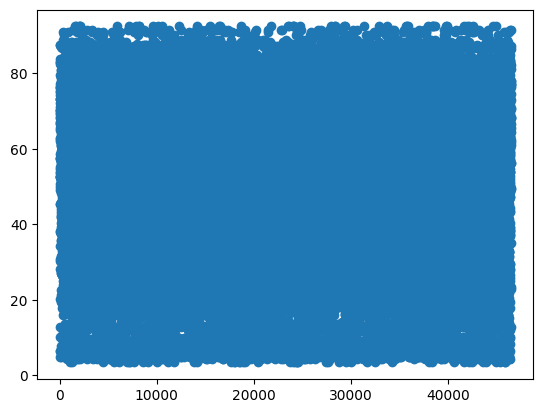

In [42]:
import matplotlib.pyplot as plt

agr = []
lbl: Tensor
for img, lbl in trainDataLoader1:
    agr.append(lbl.__array__())
agr = np.array(agr).flatten()

plt.scatter(np.arange(len(agr)), agr)


In [19]:
a = 1
b = 2
c = a + b

In [54]:
import gc
del solver
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

In [46]:
import random
# Należy to ustawić na początku skryptu lub w funkcji `train`
seed = 2137
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [55]:
solver = TReS(config,device, svPath, folder_path[config.dataset], train_index, test_index,Net, None)
srcc_computed, plcc_computed = solver.train(config.seed,svPath)

Epoch	Train_Loss	Train_SRCC	Test_SRCC	Test_PLCC	Learning_Rate	droplr


4640it [04:15, 18.19it/s]                          


  Testing... SRCC: 0.8329, PLCC: 0.8560
1	9.331		0.7668		0.8398		0.862		2e-05		0.000
Best test SRCC 0.839813, PLCC 0.862428
